In [7]:
# wk bsp qz txy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.optimize import minimize
import warnings 
warnings.filterwarnings('ignore')

# RTB Real-Time-Bidding
- 在实时竞价（RTB）启用的展示广告生态系统中，有两个重要的参与者：1. 广告交易所（Ad Exchange）和 2. 需求方平台（DSP，Demand Side Platform）。  

- 广告交易所会聚合来自多个发布商的广告展示量，并将每个广告展示的竞价请求发送给多个DSP。竞价请求包含了有关此广告位的信息，例如广告位的大小和URL，以及受众的信息，如IP地址和cookie ID或iOS IDFA。  

- 接收到竞价请求后，每个DSP都会检查广告主数据库和用户资料数据库，并使用竞价算法做出以下两个决定：

        1）决定是否对该广告展示进行竞价。如果DSP发现广告位和受众与当前至少有一个广告主正在寻找的匹配，DSP将对此广告展示进行竞价；
        2）如果DSP决定对此广告展示进行竞价，则决定适当的竞价价格，并将竞价响应发送回广告交易所。

- 广告交易所在收到所有参与DSP的竞价响应或截止日期过后进行拍卖。如果DSP赢得了拍卖，该DSP服务的广告主的广告将出现在用户的浏览器上。广告展示的实时竞价过程在附录A的图1中逐步说明。

<center>

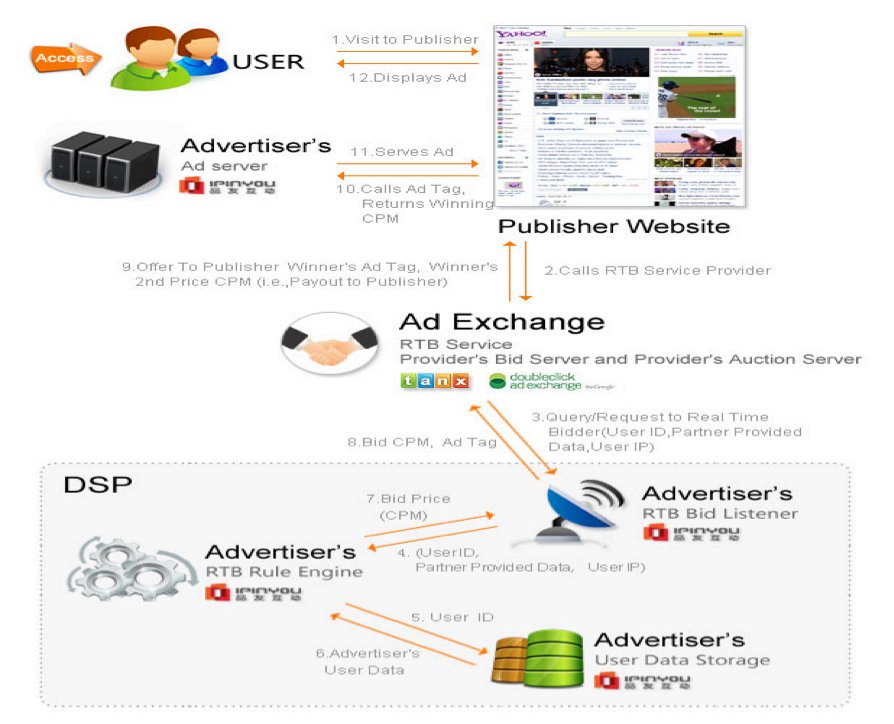

</center>

# DSP Bidding Algorithm Optimization
- 目标  

        1. DSP的竞价算法优化的目标是优化广告主的关键绩效指标（KPI），如点击量和/或转化量。  
        2. 在给定固定的广告活动预算的情况下，广告主希望获得尽可能多的点击量和/或转化量。

# Original Dataset
- iPinyou准备了一组投标、展示、点击和转化日志，这些日志来自通过爱拼游DSP生产平台运行的一些真实广告活动，在一段时间内用于训练和验证目的（训练数据集），以及来自相同一组广告活动的随后时间段的一组类似日志，用于线下测试目的（测试数据集）
- 对于每一次投标记录，第一列是投标ID，它唯一标识一个广告展示机会。在接下来的展示和点击日志中，对于同一个广告展示机会，投标ID是相同的。爱拼游在发布日志之前对投标ID应用了哈希函数。投标ID可用于连接投标、展示和点击日志

## 1. Bidding Log
<span style="font-size: 16px;">

每行投标日志都包含来自三个维度的信息，即用户、广告位和投标信息。
- 时间戳列是投标请求到达DSP投标服务器的时间。
- iPinYou ID是由iPinYou设置的用户cookie。iPinYou在发布日志之前对cookie ID应用哈希函数以保护用户隐私。
- 用户代理是用户通过浏览器访问发布者网站的用户代理。
- IP地址是用户IP地址的前三个字节。iPinYou在发布日志之前删除了最后一个字节以保护用户隐私。
- 地区ID是用户访问的地区（也称为省或州）ID，城市ID是用户访问的城市。
- 广告交易所列代表此广告展示来自哪个广告交易所。目前，该值可以是1、2、3、4、5或6，分别表示阿里巴巴的Tanx、谷歌的Adx（Google DoubleClick AdX）、腾讯、百度、优酷或谷歌移动的Amx。
- URL是广告展示将显示的位置。发布者可能要求广告交易所不将此信息传递给DSP。如果是这样，Anonymous URL ID是广告交易所设置的域页面ID。URL和Anonymous URL ID中只有一个是有意义的，而不是两个都有。
- 广告位ID是显示广告展示将显示在网页上的位置的唯一ID。一个网页可以有多个广告位。广告位宽度和广告位高度分别显示广告位的宽度和高度。这两列都可以是一个数组，这意味着发布者允许多个广告创意的宽度和高度。广告位可见性列表示广告位是否在页面上折叠之上（1）、折叠之下（2）或未知（0）。广告位格式可以是固定广告位（1）或弹出窗口（2）。
- 广告位底价是发布者允许DSP赢得广告位的最低价格。`如果没有DSP出价高于底价，此拍卖就没有获胜的DSP。iPinYou在发布日志之前对投标价格进行线性缩放。价格单位是RMB元每CPM。`
- 创意ID是DSP为其在交易所上投标的广告创意。
- 投标价格是DSP在交易所上投标的价格。`iPinYou在发布日志之前对投标价格进行线性缩放。价格单位是RMB元每CPM。`
- 广告主ID在第二季和第三季添加。它代表广告主。用户配置文件ID列在第二季和第三季的投标和展示/点击/转化日志文件中添加。但出于安全原因，投标日志文件中的用户配置文件ID始终设置为null。它们是一组数字，是DAAT（数字受众广告分类）类别名称的ID。DAAT的类别ID和类别名称将在第2.5节用户配置文件中描述。

</span>

## 2. Impression,Click and Conversion Log
<span style="font-size: 16px;">

- Impression,Click和Conversion Log日志中，大多数列与投标日志的列相同。
- 日志类型指示日志的类型：1（印象）、2（点击）或3（转化）。
- 支付价格是获胜的DSP在交易所上实际支付的价格。iPinYou在发布日志之前对投标价格进行线性缩放(Linear Scale，我们的论文里也说到这个：6.Numerical Analysis)。价格单位是RMB元每CPM。
- 落地页URL是用户点击广告创意后访问的URL。  
iPinYou在发布日志之前应用哈希函数。在第一季中，没有提供广告主ID，因此落地页URL也用于区分不同的广告主。广告主类别在第二季和第三季的数据集中，广告主ID列可用于识别广告主。在第一季中，没有广告主ID列，但可以使用落地页URL作为区分不同广告主的关键。表1列出了所有广告主类别。
</span>

# iPinYou RTB Bidding Algorithm Competition Dataset

**作者**: Hairen Liao, Lingxiao Peng, Zhenchuan Liu, Xuehua Shen  
**公司**: iPinYou Inc.  
**链接**: [iPinYou Dataset Paper](http://dx.doi.org/10.1145/2648584.2648590)  
**下载地址**: [Baidu WebDrive](http://pan.baidu.com/s/1kTwX2mF) | [University College London](http://data.computational-advertising.org)

## 简介

RTB（实时竞价）是近年来计算广告领域最令人兴奋的进展之一。它提高了广告展示生态系统的透明度和效率，促进了行业的健康发展。为了激发对 DSP 竞价算法的研究兴趣，iPinYou 在 2013 年组织了全球 RTB 竞价算法竞赛，并公开发布了三季的竞赛数据集。

## 数据集概览

iPinYou 提供的每个数据集包括以下数据：

1. **竞价日志（Bidding Log）**
2. **展示、点击和转化日志（Impression, Click, and Conversion Log）**
3. **广告主类别（Advertiser Category）**
4. **测试数据文件（Testing Data File）**
5. **用户画像（User Profile）**
6. **地区和城市文件（Region and City File）**
7. **反垃圾过滤（Anti-Spam Filtering）**
8. **基准分数（Benchmark）**

### 数据集文件格式

每个日志文件的列格式如下：

#### 竞价日志（Bidding Log）
| 序号 | 列名 | 示例 | 说明 |
|------|------|------|------|
| 1 | Bid ID\* | `c0550000008e5a94ac18823d6f275121` | 唯一标识每次广告竞价机会的 ID |
| 2 | Timestamp | `20130218134701883` | 请求到达 DSP 服务器的时间 |
| 3 | iPinYou ID\* | `35605620124122340227135` | 用户的唯一标识符 |
| 4 | User-Agent | `Mozilla/5.0 ...` | 浏览器及操作系统信息 |
| 5 | IP\* | `119.163.222.*` | 用户的 IP 地址 |
| 6 | Region ID | `146` | 地区 ID |
| 7 | City ID | `147` | 城市 ID |
| 8 | Ad Exchange | `2` | 广告交换平台 |
| 9 | Domain\* | `e80f4ec7f5bfbc9ca416a8c01cd1a049` | 广告插入的网页的域名 |
| 10 | URL\* | `hz55b000008e5a94ac18823d6f275121` | 完整 URL 地址 |
| 11 | Anonymous URL | `null` | 匿名 URL ID |
| 12 | Ad Slot ID | `973726 9023493` | 广告位 ID |
| 13 | Ad Slot Width | `300` | 广告位宽度 |
| 14 | Ad Slot Height | `250` | 广告位高度 |
| 15 | Ad Slot Visibility | `FirstView` | 广告位的可见性 |
| 16 | Ad Slot Format | `Na` | 广告位格式 |
| 17 | Ad Slot Floor Price | `0` | 广告位底价 |
| 18 | Creative ID | `f80f4ec7f5bfbc9ca416a8c01cd1a049` | 创意内容 |
| 19 | Bidding Price\* | `573` | DSP 出价 |
| 20 | Advertiser ID | `2259` | 广告主 ID |
| 21 | User Profile IDs\* | `null` | 用户画像 ID |

#### 展示、点击和转化日志（Impression, Click, and Conversion Log）
| 序号 | 列名 | 示例 | 说明 |
|------|------|------|------|
| 1 | Bid ID\* | `01530000008a77e7ac18823f5a4f5121` | 唯一标识每次广告竞价机会的 ID |
| 2 | Timestamp | `20130218134701883` | 请求到达 DSP 服务器的时间 |
| 3 | Log Type | `1` | 日志类型：1 表示展示，2 表示点击，3 表示转化 |
| 4 | iPinYou ID\* | `35605620124122340227135` | 用户的唯一标识符 |
| 5 | User-Agent | `Mozilla/5.0 ...` | 浏览器及操作系统信息 |
| 6 | IP\* | `118.81.189.*` | 用户的 IP 地址 |
| 7 | Region ID | `15` | 地区 ID |
| 8 | City ID | `16` | 城市 ID |
| 9 | Ad Exchange | `2` | 广告交换平台 |
| 10 | Domain\* | `e80f4ec7f5bfbc9ca416a8c01cd1a049` | 广告插入的网页的域名 |
| 11 | URL\* | `hz55b000008e5a94ac18823d6f275121` | 完整 URL 地址 |
| 12 | Anonymous URL | `null` | 匿名 URL ID |
| 13 | Ad Slot ID | `2147689 8764813` | 广告位 ID |
| 14 | Ad Slot Width | `300` | 广告位宽度 |
| 15 | Ad Slot Height | `250` | 广告位高度 |
| 16 | Ad Slot Visibility | `SecondView` | 广告位的可见性 |
| 17 | Ad Slot Format | `Fixed` | 广告位格式 |
| 18 | Ad Slot Floor Price | `0` | 广告位底价 |
| 19 | Creative ID | `e39e178ffdf366606f8cab791ee56bcd` | 创意内容 |
| 20 | Bidding Price\* | `753` | DSP 出价 |
| 21 | Paying Price\* | `15` | DSP 实际支付的金额 |
| 22 | Landing Page URL\* | `a8be178ffdf366606f8cab791ee56bcd` | 着陆页 URL |
| 23 | Advertiser ID | `3358` | 广告主 ID |
| 24 | User Profile IDs\* | `123,5678,3456` | 用户画像 ID |

**注**: 带 `*` 的列在发布前已被哈希或修改。

### 广告主类别（Advertiser Category）

广告主类别表格如下：

| 广告主 Key | Season | 工业类别 |
|-------------|--------|----------|
| `df6f61b2409f4e2f16b6873a7eb50444` | 1 | Consumer Packaged Goods (CPG) |
| `3a7eb50444df6f61b2409f4e2f16b687` | 1 | Chinese vertical e-commerce |
| `9f4e2f16b6873a7eb504df6f61b24044` | 1 | Vertical online media |
| `1458` | 2 | Chinese vertical e-commerce |
| `3358` | 2 | Software |
| `3386` | 2 | International e-commerce |
| `3427` | 2 | Oil |
| `3476` | 2 | Tire |
| `2259` | 3 | Milk powder |
| `2261` | 3 | Telecom |
| `2821` | 3 | Footwear |
| `2997` | 3 | Mobile e-commerce app install |

# iPinYou 数据集列名解释

| 列名          | 含义                                                                                 |
|---------------|--------------------------------------------------------------------------------------|
| **click**     | 点击次数，指广告的点击次数。如果值为 `1`，表示广告被点击；否则为 `0`。             |
| **weekday**   | 一周中的某天，`0-6` 表示从周日到周六。                                              |
| **hour**      | 小时，表示广告请求发出的小时。                                                      |
| **bidid**     | Bid ID，唯一标识每次广告竞价机会的 ID。                                             |
| **timestamp** | 时间戳，表示广告请求发出的时间。                                                    |
| **logtype**   | 日志类型，`1` 表示展示（impression）；`2` 表示点击（click）；`3` 表示转化（conversion）。 |
| **ipinyouid** | iPinYou ID，为每个用户分配的唯一标识符，表示用户的 cookie ID。                       |
| **useragent** | 用户代理（User Agent），表示用户的浏览器及操作系统信息。                            |
| **IP**        | IP 地址，用户所在的 IP 地址。最后一个字节被删除以保护用户隐私。                      |
| **region**    | 地区 ID，表示用户所在的省/州。                                                       |
| **city**      | 城市 ID，表示用户所在的城市。                                                       |
| **adexchange**| 广告交换平台 ID，目前的值为 `1-6`，分别代表 Tanx（阿里巴巴）、Adx（谷歌 DoubleClick AdX）、腾讯广告、百度、优酷或 Amx（谷歌移动广告）。 |
| **domain**    | 域名，广告插入的网页的域名。                                                        |
| **url**       | URL，广告插入的网页的完整 URL 地址。                                                |
| **urlid**     | 匿名 URL ID，如果发布者不允许广告交换平台传递完整 URL 信息，则提供匿名 URL ID。     |
| **slotid**    | 广告位 ID，表示广告显示的位置。                                                     |
| **slotwidth** | 广告位宽度。                                                                        |
| **slotheight**| 广告位高度。                                                                        |
| **slotvisibility** | 广告位的可见性，`0` 表示未知；`1` 表示可见；`2` 表示不可见。                    |
| **slotformat**| 广告位格式，`1` 表示固定广告位；`2` 表示弹出窗口。                                  |
| **slotprice** | 广告位底价，即广告位允许 DSP 赢得该广告位的最低价格。                               |
| **creative**  | 创意 ID，表示广告的具体创意内容。                                                   |
| **bidprice**  | 竞价价格，DSP 对该广告位的出价。                                                    |
| **payprice**  | 支付价格，DSP 实际支付的金额。                                                      |
| **keypage**   | 着陆页 URL，如果用户点击广告，则指向该着陆页。                                     |
| **advertiser**| 广告主 ID，表示广告主的唯一标识符。                                                 |
| **usertag**   | 用户标签 ID 列表，表示用户的多种属性信息。                                         |
| **nclick**    | 广告点击次数，记录该广告插入网页后的点击次数。                                     |
| **nconversation** | 广告转化次数，记录该广告插入网页后的转化次数。                                  |


In [8]:
# test
file_path = r".\\make-ipinyou-data\\all\\test.log.txt"
test_log = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')
test_log.sort_values(by = 'timestamp',inplace = True) # 按照时间排序

# train
# file_path = r".\\make-ipinyou-data\\all\\train.log.txt"
# train_log = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')

# click
# file_path = r".\\make-ipinyou-data\\all\\clk.all.txt"
# click_log = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')

In [9]:
print(test_log.columns)
display(test_log.head())

Index(['click', 'weekday', 'hour', 'bidid', 'timestamp', 'logtype',
       'ipinyouid', 'useragent', 'IP', 'region', 'city', 'adexchange',
       'domain', 'url', 'urlid', 'slotid', 'slotwidth', 'slotheight',
       'slotvisibility', 'slotformat', 'slotprice', 'creative', 'bidprice',
       'payprice', 'keypage', 'advertiser', 'usertag', 'nclick',
       'nconversation'],
      dtype='object')


,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag,nclick,nconversation
0,0,4,0,82aed71bea7358c9a5be868deae30be0,20130613000101373,1,Vh5KZAnrPQTPJIC,windows_chrome,60.187.41.*,94,...,1,0,cc9b344e950b4f8c2b96537174a343b7,227,29,d29e59bf0f7f8243858b8183f14d4412,3358,10063,0,0
1,0,4,0,77c5c149c234a0de420eefe9b6e16517,20130613000101391,1,Vh1HP3FpOUx6kgL,windows_chrome,221.0.14.*,146,...,1,0,fa8f0532dd5144b5fa748459e8d90b49,227,20,0f951a030abdaedd733ee8d114ce2944,3427,"13403,10006,10063,13866,10126,10117,10110",0,0
2,0,4,0,a45fe947ffb7a52f452308bb50b4a572,20130613000101428,1,Vh5zPuc9DvT2lGk,windows_theworld,180.173.50.*,79,...,0,5,7184c9560e68e977187e67e45a4f3198,238,63,0f951a030abdaedd733ee8d114ce2944,3427,"13042,10052,10075,10006,10031,10063,13800,1013...",0,0
3,0,4,0,184d6f9a71c3c53336cff407e5b7ae,20130613000101438,1,Vh5KZAnrPoddkMf,windows_chrome,175.148.162.*,40,...,5,0,44966cc8da1ed40c95d59e863c8c75f0,300,293,361e128affece850342293213691a043,3386,"13866,10111",0,0
4,0,4,0,11415ce7ca9c7e1950b41bf3468fb288,20130613000101456,1,VhdiPkNq3QNvwQL,windows_chrome,111.179.205.*,183,...,1,0,911b2d84826786018761e8c0b0a3a60c,227,120,d29e59bf0f7f8243858b8183f14d4412,3358,"13042,10031,10063,10006,10075,10126,10116,10110",0,0


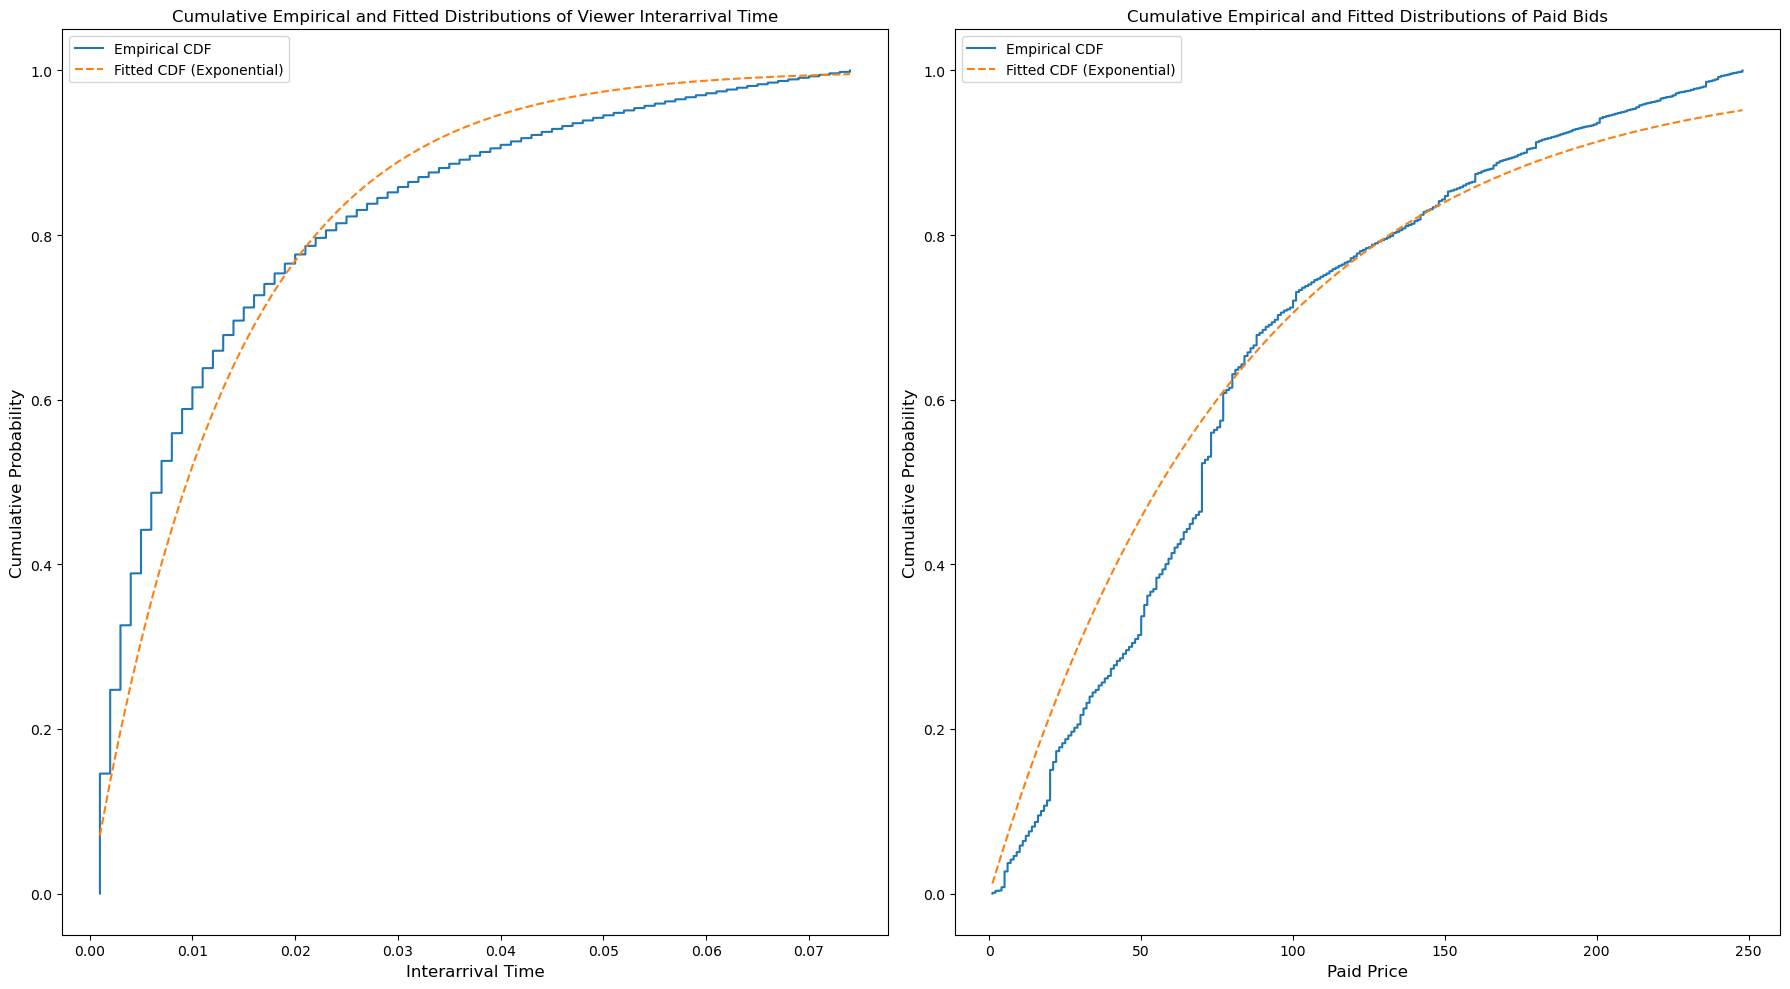

In [10]:
# 论文中假设是Possion Arrival，这里检验一下
test_log['timestamp'] = pd.to_datetime(test_log['timestamp'], format='%Y%m%d%H%M%S%f')
# 计算 Viewer Interarrival Time
impressions = test_log[test_log['logtype'] == 1].sort_values(by='timestamp')
impressions = impressions.copy()
impressions['interarrival_time'] = impressions['timestamp'].diff().dt.total_seconds().fillna(0)
# 计算 Paid Bids Paid Prices
paid_bids = impressions[impressions['payprice'] > 0].copy()

# 使用 IQR 去除异常值
def remove_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

# 去除异常值 论文里也这么干了
impressions['interarrival_time'] = remove_outliers_iqr(impressions['interarrival_time']) 
paid_bids['payprice'] = remove_outliers_iqr(paid_bids['payprice'])

# 绘制累积经验和拟合分布
def plot_empirical_and_fitted_cdf(data, title, ax, xlabel = None):
    # 排除0值并对数据进行排序
    data = data[data > 0]
    data_sorted = np.sort(data)
    # Empirical CDF（观测到的）
    y_vals = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    ax.plot(data_sorted, y_vals, label='Empirical CDF')
    # 拟合指数分布
    loc, scale = stats.expon.fit(data_sorted, floc=0) # 这的scale是 1/λ, loc是位置平移参数，这里不平移
    fitted_cdf = stats.expon.cdf(data_sorted, loc=loc, scale=scale)
    ax.plot(data_sorted, fitted_cdf, label='Fitted CDF (Exponential)', linestyle='dashed')
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel(f'{xlabel}',fontsize = 12)
    else:
        ax.set_xlabel(f'{data.name}',fontsize = 12)
    ax.set_ylabel('Cumulative Probability',fontsize = 12)
    ax.legend()
    
# 绘制 Viewer 和 Paid Bids 的 CDF 图
fig, axs = plt.subplots(1, 2, figsize=(18, 10))
plot_empirical_and_fitted_cdf(impressions['interarrival_time'], 'Cumulative Empirical and Fitted Distributions of Viewer Interarrival Time', axs[0],'Interarrival Time')
plot_empirical_and_fitted_cdf(paid_bids['payprice'], 'Cumulative Empirical and Fitted Distributions of Paid Bids', axs[1], 'Paid Price')
plt.tight_layout()
plt.show()


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.274011,0.138477,0.166792,0.110107,0.092809,0.064553,0.048130,0.033424,0.023617,0.016210,0.011169,0.007603,0.005216,0.003570,0.002516,0.001796
Opt b,0.000000,1.259417,1.706082,2.021372,2.270226,2.476735,2.652553,2.804198,2.933074,3.041480,3.122274,3.184092,3.180420,3.165918,2.997349,2.829480
Opt w,0.000000,0.395750,0.494614,0.554496,0.596706,0.628681,0.653898,0.674268,0.690634,0.703762,0.713183,0.720188,0.719777,0.718146,0.698486,0.677545


Optimal Expected Profit: 0.59


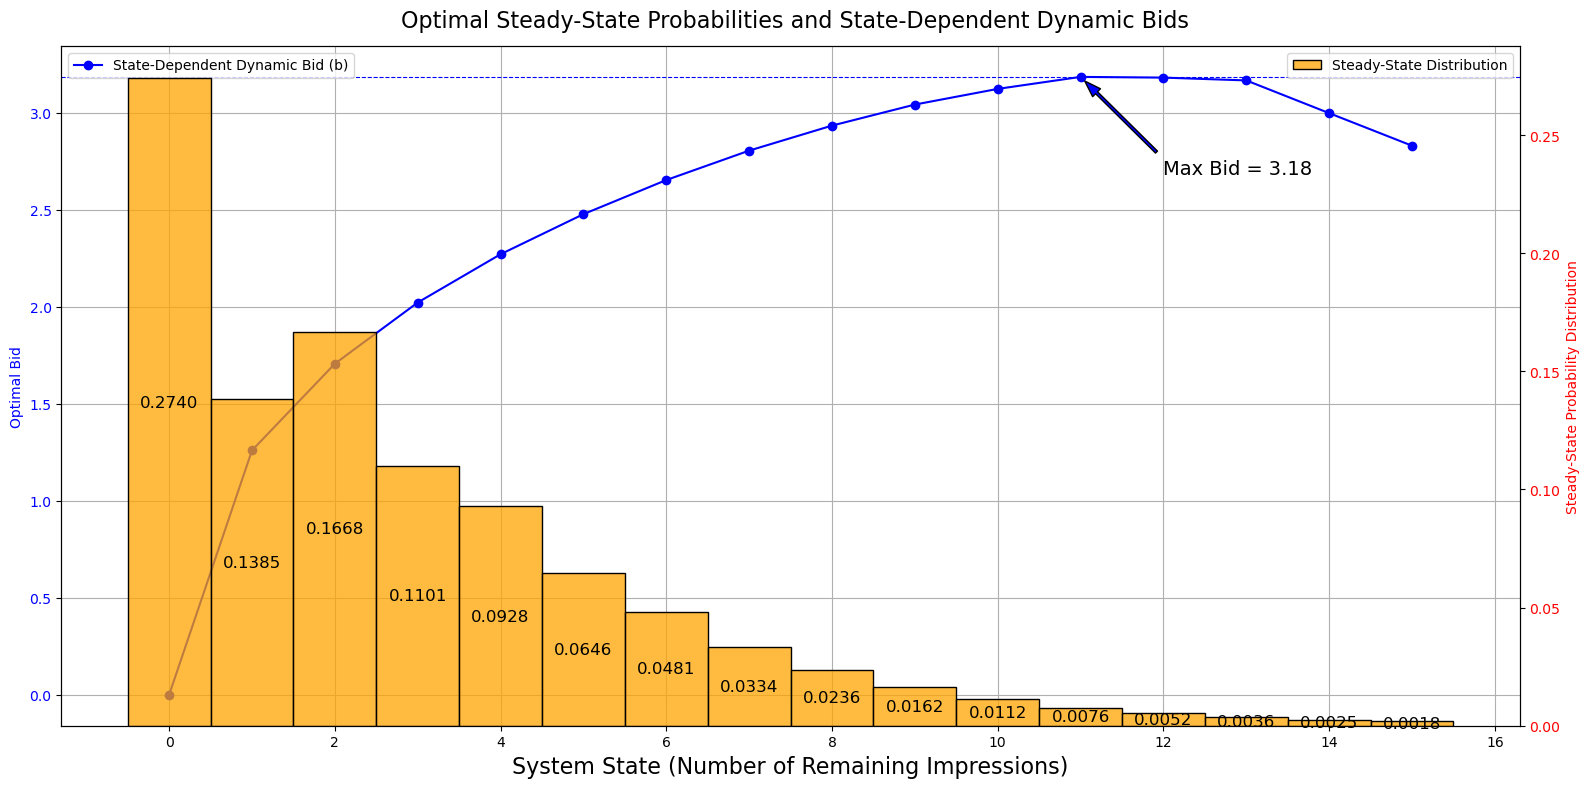

In [11]:
# 6.1 Numerical Analysis --- Heuristic Method
# 基本案例参数
mu_base = 1.0
lambda_Cap_base = 0.2
lambda_Imp_base = 0.4
A_base = 15
revenue_base = 5
dcost_base = 0.2

# 竞价成功概率函数
def winning_func_base(bidding):
    return 1 - np.exp(-0.4 * bidding)

# 计算广告活动请求的概率分布
def compute_q(A, s=2):
    """
    计算广告活动请求的概率分布
    :param A: 最大队列长度
    :param s: 每个广告活动请求的展示次数
    :return: q_s 列表，广告活动请求的概率分布
    """
    q_s = np.zeros(A + 1)
    q_s[s] = 1
    return q_s

# 计算稳态平衡方程
def steady_state_equations(params, A, q_s, mu, rho_0):
    """
    计算稳态平衡方程
    :param params: 参数列表（包含稳态概率 x 和竞价 b）
    :param A: 最大队列长度
    :param q_s: 广告活动请求的概率分布
    :param mu: 单位时间内的用户流量率
    :param rho_0: 竞价成功率和点击率的比率
    :return: 方程列表，用于最小化求解
    """
    x = params[:A + 1]
    b = params[A + 1:]
    w = winning_func_base(b)

    eqs = [x[0] - rho_0 * x[1] * w[1]]  # 公式 (9)

    for a in range(1, A):
        eq = x[a] * (1 + rho_0 * w[a]) - sum(x[e] * q_s[a - e] for e in range(a)) - rho_0 * x[a + 1] * w[a + 1]  # 公式 (10)
        eqs.append(eq)

    eqs.append(sum(x) - 1)  # 公式 (11)

    return np.array(eqs)

# 计算利润
def profit_function(params, A, q_s, mu, revenue, dcost, rho_0):
    """
    计算稳态平衡问题中的利润函数
    :param params: 参数列表(包含稳态概率 x 和竞价 b,第0---A个是x,第A+1到最后是对应的bidding)
    :param A: 最大队列长度
    :param q_s: 广告活动请求的概率分布
    :param mu: 单位时间内的用户流量率
    :param revenue: 每次点击的收入
    :param dcost: 每次点击的惩罚费用
    :param rho_0: 竞价成功率和点击率的比率
    :return: 负的利润值（用于最小化）
    """
    x = params[:A + 1]
    b = params[A + 1:]
    w = winning_func_base(b)

    profit = mu * sum(x[a] * w[a] * (revenue - b[a]) for a in range(1, A + 1)) - dcost * sum(a * x[a] for a in range(1, A + 1))  # 公式 (8)

    return -profit  # 返回负的利润值，因为我们使用 minimize 函数

# 约束条件：保证 b[0] = 0
def initial_constraints(params,A):
    return np.array([params[A + 1]]) # b[0]是在params的第A+1个位置

# 求解稳态问题
def solve_steady_state(A, mu, revenue, dcost, lambda_Cap, q_s):
    """
    求解稳态优化问题
    :param A: 最大队列长度
    :param mu: 单位时间内的用户流量率
    :param revenue: 每次点击的收入
    :param dcost: 每次点击的惩罚费用
    :param lambda_Imp: 单位时间的展示到达率
    :param q_s: 广告活动请求的概率分布
    :return: 最优的稳态概率 x 和竞价 b
    """
    rho_0 = mu / lambda_Cap

    # 初始化参数：x 和 b
    initial_x = np.ones(A + 1) / (A + 1)
    initial_b = np.ones(A + 1)
    initial_b[0] = 0  # b[0] = 0
    initial_params = np.concatenate([initial_x, initial_b])

    # 使用非线性方程求解器
    constraints = [
        {'type': 'eq', 'fun': steady_state_equations, 'args': (A, q_s, mu, rho_0)},
        {'type': 'eq', 'fun': initial_constraints,'args':(A,)}  # b[0] = 0，这里就离谱，在使用多线程时，会调用多线程类中的run()函数，这个函数需要传入一个可迭代对象，当我们的参数只有一个整数时，单独的整数不可迭代，所以一定要在A后加个","变成(A,)
    ] 
    solution = minimize(
        profit_function, initial_params, args=(A, q_s, mu, revenue, dcost, rho_0), constraints=constraints,
        method='SLSQP', options={'maxiter': 10000, 'ftol': 1e-8}
    )
    
    if solution.success:
        x = solution.x[:A + 1]
        b = solution.x[A + 1:]
        w = winning_func_base(b)
        optimal_profit = -solution.fun
        return x, b, w, optimal_profit
    else:
        raise ValueError('Optimization did not converge.')

# 设置基本案例参数并求解
q_s_base = compute_q(A_base)
x_base, b_base, w_base, optimal_profit_base = solve_steady_state(A_base, mu_base, revenue_base, dcost_base, lambda_Cap_base, q_s_base)

# 输出结果
Result = pd.DataFrame(columns = [f'Sys State: {i}' for i in range(A_base+1)])
Result.loc['Opt x'] = x_base 
Result.loc['Opt b'] = b_base 
Result.loc['Opt w'] = w_base
# print("Optimal Steady-State Probabilities (x):", x_base)
# print("Optimal Bidding Prices (b):", b_base)
# print("Optimal Winning Probabilities (w):", w_base)
display(Result)
print(f"Optimal Expected Profit: {optimal_profit_base:.2f}")

# 找到 b_base 的最大值及其对应的索引
max_bid = np.max(b_base)
max_bid_index = np.argmax(b_base)

# 绘制结果
fig, ax1 = plt.subplots(figsize=(16, 8))
# 绘制 Optimal Bids (b)
ax1.plot(range(A_base + 1), b_base, label="State-Dependent Dynamic Bid (b)", color='blue', marker='o')
ax1.set_xlabel("System State (Number of Remaining Impressions)", fontsize=16)
ax1.set_ylabel("Optimal Bid", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc="upper left")
ax1.grid(True)

# 标注最大值并画出虚线
ax1.annotate(
    f'Max Bid = {max_bid:.2f}',
    xy=(max_bid_index, max_bid),
    xytext=(max_bid_index + 1, max_bid - 0.5),
    arrowprops=dict(facecolor='blue', shrink=0.05, width=2, headwidth=8),
    fontsize=14
)
ax1.axhline(max_bid, color='blue', linestyle='--', linewidth=0.8)

# 绘制 Steady-State Probability Distribution (x)
ax2 = ax1.twinx()
bars = sns.histplot(x=range(A_base + 1), weights=x_base, discrete=True, color='orange', label="Steady-State Distribution", ax=ax2)
ax2.set_ylabel("Steady-State Probability Distribution", color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right")

# 为每个柱子标注数值
for bar, weight in zip(bars.patches, x_base):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{weight:.4f}', ha='center', va='center', color='black', fontsize=12)

# 标题
fig.suptitle("Optimal Steady-State Probabilities and State-Dependent Dynamic Bids", fontsize=16)
plt.tight_layout()
plt.show()


# 6.4 Sensitivity Analysis for the Input Parameters

Gamma = 0.5, lambda = 0.1


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.350729,0.149013,0.172662,0.100236,0.079705,0.050223,0.035060,0.022423,0.014809,0.009444,0.006069,0.003874,0.002463,0.001567,0.001030,0.000694
Opt b,0.000000,1.590668,2.162020,2.566914,2.886164,3.151934,3.378895,3.575047,3.744081,3.883328,4.014392,4.035117,4.117962,4.135885,3.817466,3.453224
Opt w,0.000000,0.470736,0.578868,0.641837,0.684774,0.716565,0.741163,0.760696,0.776341,0.788458,0.799262,0.800920,0.807409,0.808784,0.782811,0.748746


Optimal Expected Profit: 0.06
Gamma = 1.0, lambda = 0.2


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.274011,0.138477,0.166792,0.110107,0.092809,0.064553,0.048130,0.033424,0.023617,0.016210,0.011169,0.007603,0.005216,0.003570,0.002516,0.001796
Opt b,0.000000,1.259417,1.706082,2.021372,2.270226,2.476735,2.652553,2.804198,2.933074,3.041480,3.122274,3.184092,3.180420,3.165918,2.997349,2.829480
Opt w,0.000000,0.395750,0.494614,0.554496,0.596706,0.628681,0.653898,0.674268,0.690634,0.703762,0.713183,0.720188,0.719777,0.718146,0.698486,0.677545


Optimal Expected Profit: 0.59
Gamma = 1.5, lambda = 0.30000000000000004


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.229474,0.127852,0.158275,0.112572,0.098722,0.072917,0.056818,0.041580,0.030742,0.022149,0.015970,0.011394,0.008171,0.005859,0.004308,0.003197
Opt b,0.000000,1.111693,1.501538,1.774934,1.989086,2.166048,2.316958,2.445578,2.555191,2.646489,2.714483,2.764883,2.769781,2.755335,2.634072,2.527012
Opt w,0.000000,0.358969,0.451526,0.508343,0.548705,0.579546,0.604175,0.624024,0.640153,0.653057,0.662366,0.669105,0.669752,0.667838,0.651330,0.636074


Optimal Expected Profit: 1.18
Gamma = 2.0, lambda = 0.4


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.199398,0.118581,0.149954,0.112281,0.101413,0.078141,0.062919,0.047814,0.036554,0.027291,0.020336,0.015015,0.011120,0.008230,0.006220,0.004734
Opt b,0.000000,1.024841,1.379561,1.626789,1.820186,1.979345,2.114282,2.229179,2.327636,2.407729,2.471553,2.515362,2.525283,2.520534,2.433214,2.356889
Opt w,0.000000,0.336308,0.424102,0.478328,0.517162,0.546943,0.570749,0.590030,0.605862,0.618289,0.627911,0.634374,0.635822,0.635130,0.622160,0.610447


Optimal Expected Profit: 1.80
Gamma = 2.5, lambda = 0.5


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.177388,0.110775,0.142402,0.110823,0.102439,0.081518,0.067340,0.052681,0.041344,0.031715,0.024255,0.018374,0.013940,0.010564,0.008141,0.006300
Opt b,0.000000,0.965143,1.296801,1.526161,1.704979,1.851783,1.976087,2.081767,2.172331,2.246955,2.305970,2.349168,2.364290,2.365287,2.303437,2.252234
Opt w,0.000000,0.320268,0.404718,0.456901,0.494391,0.523226,0.546353,0.565129,0.580601,0.592935,0.602432,0.609242,0.611599,0.611754,0.602028,0.593793


Optimal Expected Profit: 2.43


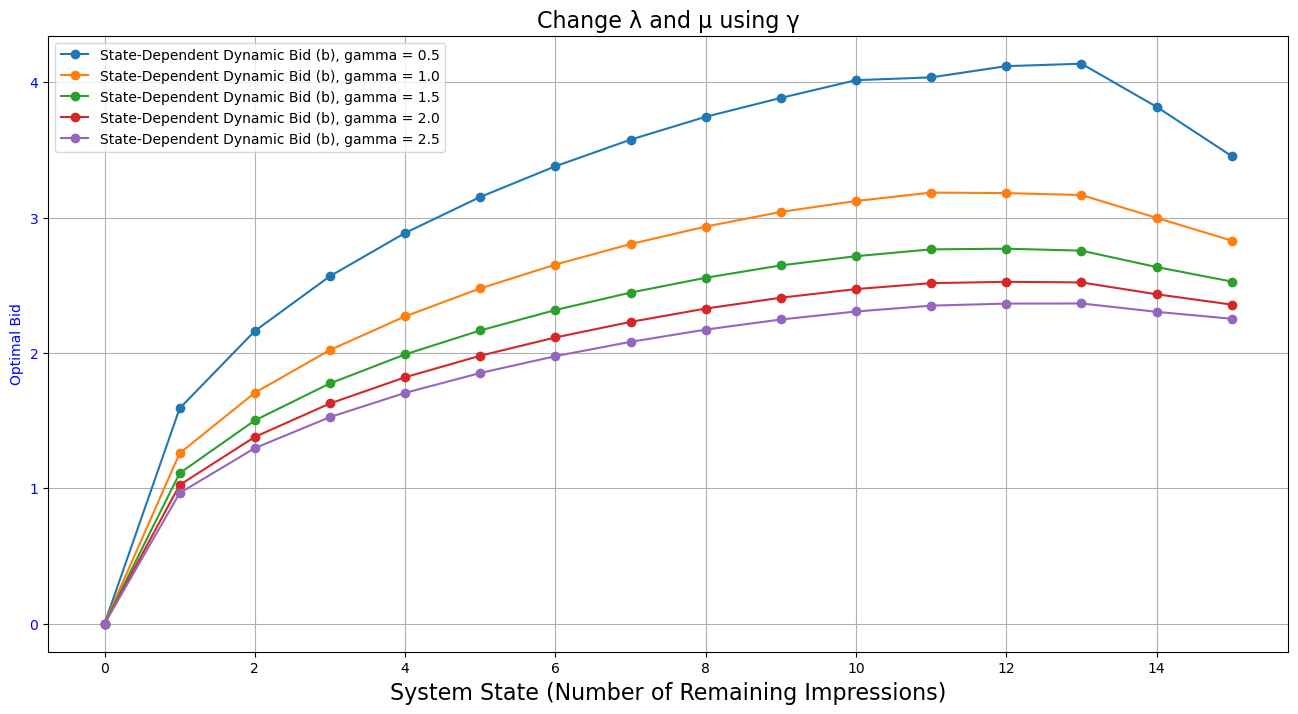

In [12]:
# 6.4.1 Arrival Rate of Transactions
gamma_list = np.arange(0.5,3,0.5)
mu_base = 1.0
lambda_Cap_base = 0.2
lambda_Imp_base = 0.4
A_base = 15
revenue_base = 5
dcost_base = 0.2
rho_0_base = mu_base / lambda_Imp_base

# 设置基本案例参数并求解
q_s_base = compute_q(A_base)
x_list,b_list,w_list,opt_profit_list = [],[],[],[]
for gamma in gamma_list: # Changing the arrival rate using gamma
    
    x_base, b_base, w_base, optimal_profit_base = solve_steady_state(A_base, mu_base*gamma, revenue_base, dcost_base, lambda_Cap_base * gamma, q_s_base)
    # 存下当前gamma下的结果
    x_list.append(x_base)
    b_list.append(b_base)
    w_list.append(w_base)
    opt_profit_list.append(optimal_profit_base)
    # 输出结果
    print(f'Gamma = {gamma}, lambda = {lambda_Cap_base * gamma}')
    Result = pd.DataFrame(columns = [f'Sys State: {i}' for i in range(A_base+1)])
    Result.loc['Opt x'] = x_base 
    Result.loc['Opt b'] = b_base 
    Result.loc['Opt w'] = w_base
    display(Result)
    print(f"Optimal Expected Profit: {optimal_profit_base:.2f}")

plt.figure(figsize = (16,8))
for idx in range(len(gamma_list)):
    x_base = x_list[idx]
    b_base = b_list[idx]
    w_base = w_list[idx] 
    optimal_profit_base = opt_profit_list[idx]
    
    # 找到 b_base 的最大值及其对应的索引
    max_bid = np.max(b_base)
    max_bid_index = np.argmax(b_base)

    # 绘制 Optimal Bids (b)
    plt.plot(range(A_base + 1), b_base, label=f"State-Dependent Dynamic Bid (b), gamma = {gamma_list[idx]}", marker='o')

plt.title('Change λ and μ using γ',fontsize = 16)
plt.xlabel("System State (Number of Remaining Impressions)", fontsize=16)
plt.ylabel("Optimal Bid", color='blue')
plt.tick_params(axis='y', labelcolor='blue')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

μ = 0.5


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.071727,0.047017,0.067159,0.060489,0.065205,0.062789,0.063061,0.061516,0.060710,0.059635,0.059083,0.058915,0.059762,0.061692,0.066796,0.074442
Opt b,0.000000,2.355444,3.071034,3.516445,3.820290,4.032911,4.176641,4.263723,4.298121,4.284574,4.215198,4.100115,3.899172,3.668509,3.248611,2.931262
Opt w,0.000000,0.610222,0.707243,0.755020,0.783056,0.800744,0.811876,0.818317,0.820799,0.819826,0.814756,0.806029,0.789794,0.769477,0.727317,0.690409


Optimal Expected Profit: -1.08
μ = 1.0


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.274011,0.138477,0.166792,0.110107,0.092809,0.064553,0.048130,0.033424,0.023617,0.016210,0.011169,0.007603,0.005216,0.003570,0.002516,0.001796
Opt b,0.000000,1.259417,1.706082,2.021372,2.270226,2.476735,2.652553,2.804198,2.933074,3.041480,3.122274,3.184092,3.180420,3.165918,2.997349,2.829480
Opt w,0.000000,0.395750,0.494614,0.554496,0.596706,0.628681,0.653898,0.674268,0.690634,0.703762,0.713183,0.720188,0.719777,0.718146,0.698486,0.677545


Optimal Expected Profit: 0.59
μ = 1.5


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.364834,0.159893,0.179025,0.101227,0.076650,0.045610,0.029815,0.017663,0.010754,0.006260,0.003663,0.002097,0.001202,0.000685,0.000392,0.000230
Opt b,0.000000,0.906848,1.239033,1.478337,1.671132,1.834913,1.978315,2.106132,2.220842,2.323937,2.414184,2.491736,2.546273,2.570293,2.563920,2.455296
Opt w,0.000000,0.304232,0.390803,0.446412,0.487499,0.519998,0.546757,0.569347,0.588661,0.605278,0.619273,0.630902,0.638867,0.642320,0.641407,0.625483


Optimal Expected Profit: 1.03
μ = 2.0


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.42362,0.166606,0.178107,0.090135,0.063710,0.034024,0.020436,0.010877,0.006018,0.003143,0.001657,0.000847,0.000438,0.000212,0.000110,0.000059
Opt b,0.00000,0.733461,1.006378,1.204947,1.366283,1.504443,1.626441,1.736306,1.836433,1.928324,2.012157,2.091304,2.120913,2.320048,2.220746,1.985600
Opt w,0.00000,0.254265,0.331388,0.382440,0.421035,0.452163,0.478255,0.500687,0.520290,0.537602,0.552851,0.566785,0.571886,0.604664,0.588645,0.548076


Optimal Expected Profit: 1.23
μ = 2.5


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.466698,0.168191,0.173893,0.080650,0.054220,0.026632,0.015036,0.007376,0.003805,0.001832,0.000895,0.000421,0.000201,0.000088,0.000042,0.000021
Opt b,0.000000,0.627524,0.863568,1.036243,1.177301,1.298550,1.406127,1.503373,1.592668,1.675283,1.751912,1.825151,1.857490,2.090338,1.966894,1.698788
Opt w,0.000000,0.221985,0.292082,0.339328,0.375573,0.405134,0.430189,0.451928,0.471159,0.488349,0.503794,0.518120,0.524313,0.566618,0.544681,0.493137


Optimal Expected Profit: 1.35
μ = 3.0


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.500329,0.167553,0.168854,0.072855,0.047108,0.021605,0.011621,0.005335,0.002605,0.001174,0.000540,0.000242,0.000099,0.000045,0.000022,0.000012
Opt b,0.000000,0.554964,0.765268,0.919819,1.046616,1.155796,1.252897,1.341120,1.422350,1.497930,1.571329,1.597087,1.858806,1.758246,1.480977,1.197661
Opt w,0.000000,0.199073,0.263692,0.307833,0.342063,0.370178,0.394172,0.415178,0.433875,0.450734,0.466626,0.472093,0.524564,0.505050,0.446996,0.380637


Optimal Expected Profit: 1.43
μ = 3.5


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.527643,0.165882,0.163762,0.066425,0.041624,0.018008,0.009313,0.004043,0.001888,0.000805,0.000357,0.000141,0.000062,0.000028,0.000014,0.000007
Opt b,0.000000,0.501506,0.692670,0.833722,0.949533,1.049623,1.138817,1.220068,1.295187,1.366401,1.411826,1.591721,1.518592,1.350991,1.199849,1.089198
Opt w,0.000000,0.181762,0.241997,0.283580,0.316011,0.342854,0.365886,0.386164,0.404334,0.421062,0.431487,0.470958,0.455255,0.417483,0.381179,0.353175


Optimal Expected Profit: 1.49
μ = 4.0


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.550484,0.163716,0.158881,0.061062,0.037271,0.015329,0.00767,0.003173,0.001427,0.000580,0.000246,0.000094,0.000040,0.000017,0.000007,0.000003
Opt b,0.000000,0.460173,0.636453,0.766841,0.874113,0.966914,1.04976,1.125117,1.194696,1.262457,1.308111,1.452060,1.399166,1.279332,1.191864,1.135577
Opt w,0.000000,0.168122,0.224759,0.264155,0.295062,0.320750,0.34289,0.362402,0.379902,0.396484,0.407405,0.440563,0.428600,0.400544,0.379200,0.365064


Optimal Expected Profit: 1.53


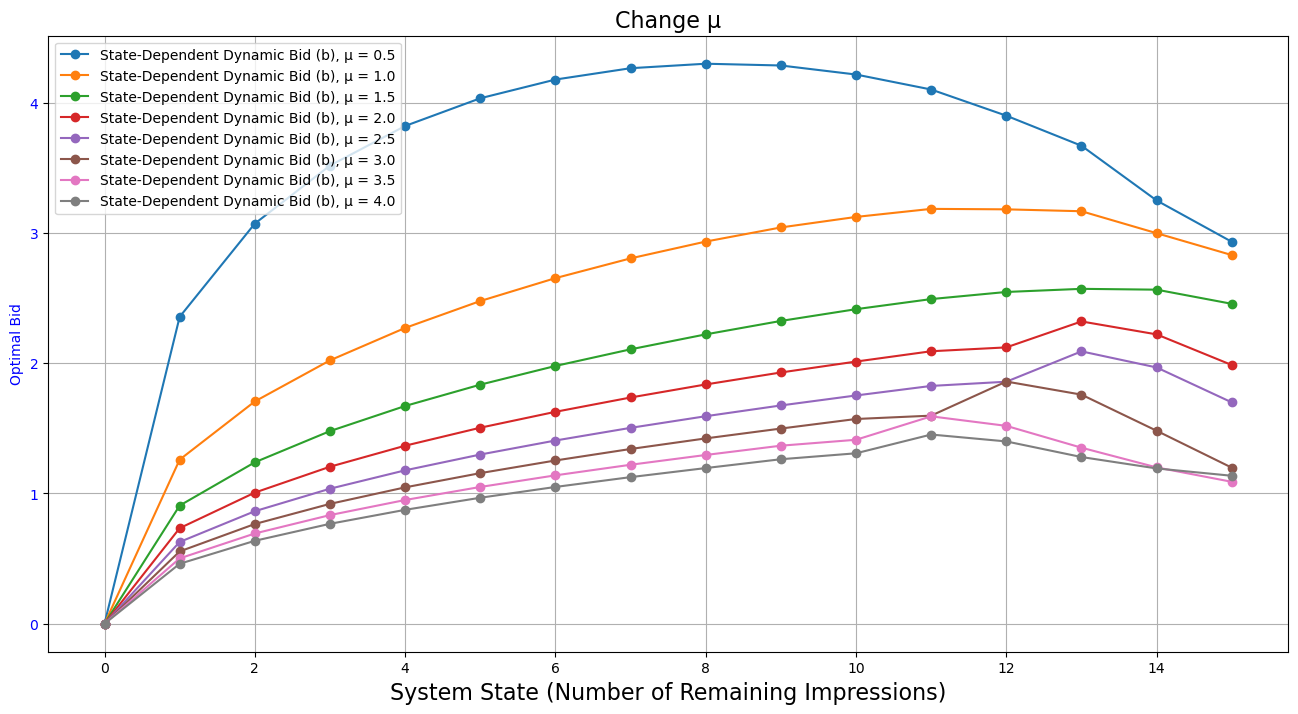

In [13]:
# 6.4.2 Arrival Rate of Viewers μ  就是lambda 和 mu varied separately
mu_list = np.arange(0.5,4.5,0.5)
lambda_Cap_base = 0.2
lambda_Imp_base = 0.4
A_base = 15
revenue_base = 5
dcost_base = 0.2
rho_0_base = mu_base / lambda_Imp_base

# 设置基本案例参数并求解
q_s_base = compute_q(A_base)
x_list,b_list,w_list,opt_profit_list = [],[],[],[]
for mu_base in mu_list: 
    
    x_base, b_base, w_base, optimal_profit_base = solve_steady_state(A_base, mu_base, revenue_base, dcost_base, lambda_Cap_base, q_s_base)
    # 存下当前gamma下的结果
    x_list.append(x_base)
    b_list.append(b_base)
    w_list.append(w_base)
    opt_profit_list.append(optimal_profit_base)
    # 输出结果
    print(f'μ = {mu_base}')
    Result = pd.DataFrame(columns = [f'Sys State: {i}' for i in range(A_base+1)])
    Result.loc['Opt x'] = x_base 
    Result.loc['Opt b'] = b_base 
    Result.loc['Opt w'] = w_base
    display(Result)
    print(f"Optimal Expected Profit: {optimal_profit_base:.2f}")

plt.figure(figsize = (16,8))
for idx in range(len(mu_list)):
    x_base = x_list[idx]
    b_base = b_list[idx]
    w_base = w_list[idx] 
    optimal_profit_base = opt_profit_list[idx]
    
    # 找到 b_base 的最大值及其对应的索引
    max_bid = np.max(b_base)
    max_bid_index = np.argmax(b_base)

    # 绘制 Optimal Bids (b)
    plt.plot(range(A_base + 1), b_base, label=f"State-Dependent Dynamic Bid (b), μ = {mu_list[idx]}", marker='o')

plt.title('Change μ',fontsize = 16)
plt.xlabel("System State (Number of Remaining Impressions)", fontsize=16)
plt.ylabel("Optimal Bid", color='blue')
plt.tick_params(axis='y', labelcolor='blue')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

λ = 0.05


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.708992,0.126668,0.113876,0.028306,0.015167,0.004312,0.001825,0.000555,0.000190,0.000064,0.000025,0.000011,0.000005,0.000002,0.000001,6.765813e-07
Opt b,0.000000,0.820781,1.142879,1.383038,1.581225,1.753252,1.907746,2.014423,2.457514,2.158898,1.761879,1.383144,1.127431,0.946726,0.851723,8.053723e-01
Opt w,0.000000,0.279862,0.366916,0.424902,0.468733,0.504060,0.533780,0.553256,0.625815,0.578341,0.505769,0.424927,0.362992,0.315242,0.288720,2.754097e-01


Optimal Expected Profit: 0.28
λ = 0.1


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.512512,0.162056,0.165390,0.070113,0.046104,0.021305,0.011744,0.005524,0.002790,0.001304,0.000636,0.000277,0.000132,0.000063,0.000034,0.000019
Opt b,0.000000,0.950432,1.310054,1.573209,1.787514,1.971394,2.133200,2.280058,2.412284,2.538037,2.579420,3.015545,2.953858,2.618948,2.146569,1.752640
Opt w,0.000000,0.316257,0.407866,0.467027,0.510811,0.545500,0.573985,0.598289,0.618984,0.637675,0.643624,0.700673,0.693195,0.649214,0.576257,0.503939


Optimal Expected Profit: 0.49
λ = 0.2


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.274011,0.138477,0.166792,0.110107,0.092809,0.064553,0.048130,0.033424,0.023617,0.016210,0.011169,0.007603,0.005216,0.003570,0.002516,0.001796
Opt b,0.000000,1.259417,1.706082,2.021372,2.270226,2.476735,2.652553,2.804198,2.933074,3.041480,3.122274,3.184092,3.180420,3.165918,2.997349,2.829480
Opt w,0.000000,0.395750,0.494614,0.554496,0.596706,0.628681,0.653898,0.674268,0.690634,0.703762,0.713183,0.720188,0.719777,0.718146,0.698486,0.677545


Optimal Expected Profit: 0.59
λ = 0.3


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.129027,0.081560,0.109804,0.090922,0.090133,0.078284,0.070907,0.061651,0.054107,0.046909,0.040866,0.035626,0.031442,0.02807,0.026050,0.024641
Opt b,0.000000,1.608959,2.141264,2.495188,2.757277,2.959099,3.116807,3.236401,3.319861,3.370700,3.382747,3.359422,3.271879,3.15383,2.890809,2.689061
Opt w,0.000000,0.474594,0.575357,0.631412,0.668096,0.693838,0.712555,0.725982,0.734979,0.740313,0.741562,0.739139,0.729843,0.71678,0.685359,0.658915


Optimal Expected Profit: 0.18
λ = 0.4


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.035471,0.026905,0.040099,0.040010,0.045908,0.048031,0.051751,0.054560,0.058047,0.061713,0.066272,0.071858,0.079420,0.089420,0.104942,0.125593
Opt b,0.000000,1.873490,2.433575,2.770651,2.993245,3.142802,3.237427,3.287628,3.297388,3.272117,3.207890,3.115759,2.974326,2.822965,2.578924,2.412534
Opt w,0.000000,0.527348,0.622215,0.669867,0.697991,0.715528,0.726094,0.731539,0.732585,0.729869,0.722839,0.712434,0.695697,0.676704,0.643553,0.619022


Optimal Expected Profit: -0.49
λ = 0.45


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.014163,0.011809,0.018547,0.020294,0.025075,0.028724,0.033738,0.039077,0.045705,0.053645,0.063754,0.076703,0.094240,0.117973,0.153526,0.203028
Opt b,0.000000,1.939703,2.486816,2.795222,2.985473,3.101332,3.160866,3.176153,3.154949,3.104990,3.020411,2.917934,2.776877,2.639251,2.432254,2.301751
Opt w,0.000000,0.539702,0.630175,0.673096,0.697051,0.710770,0.717576,0.719298,0.716907,0.711193,0.701255,0.688755,0.670688,0.652051,0.622015,0.601760


Optimal Expected Profit: -0.73
λ = 0.5


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.005171,0.004736,0.007841,0.009379,0.012463,0.015585,0.019908,0.025229,0.032307,0.041650,0.054424,0.072098,0.097525,0.134247,0.191328,0.276110
Opt b,0.000000,1.973998,2.497649,2.774911,2.934619,3.016332,3.047288,3.038646,2.998001,2.933570,2.844272,2.743619,2.615051,2.497500,2.326573,2.226406
Opt w,0.000000,0.545973,0.631774,0.670429,0.690825,0.700767,0.704449,0.703426,0.698565,0.690695,0.679447,0.666278,0.648667,0.631752,0.605695,0.589575


Optimal Expected Profit: -0.88


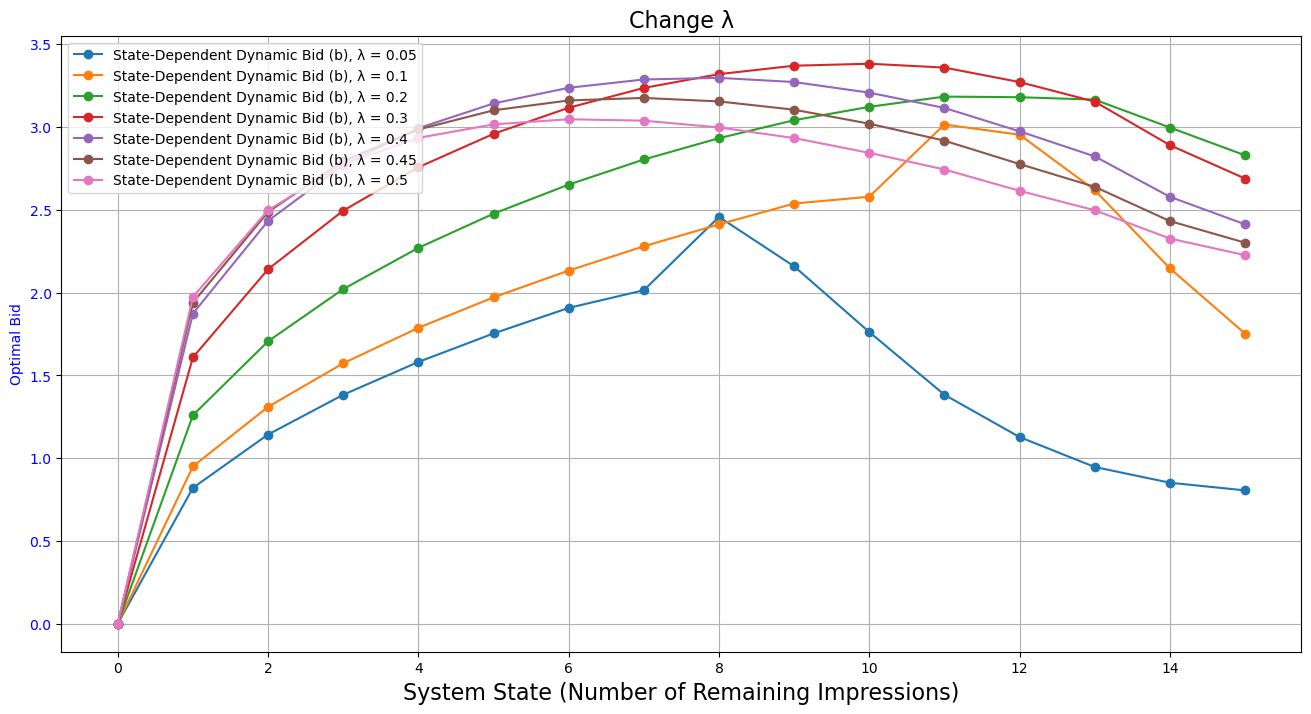

In [14]:
# 6.4.3 Arrival Rate of Campaigns λ
mu_base = 1.0
lambda_Cap_list = [0.05,0.1,0.2,0.3,0.4,0.45,0.5]
A_base = 15
revenue_base = 5
dcost_base = 0.2
rho_0_base = mu_base / lambda_Imp_base

# 设置基本案例参数并求解
q_s_base = compute_q(A_base)
x_list,b_list,w_list,opt_profit_list = [],[],[],[]
for lambda_Cap_base in lambda_Cap_list:
    x_base, b_base, w_base, optimal_profit_base = solve_steady_state(A_base, mu_base, revenue_base, dcost_base, lambda_Cap_base, q_s_base)
    # 存下当前gamma下的结果
    x_list.append(x_base)
    b_list.append(b_base)
    w_list.append(w_base)
    opt_profit_list.append(optimal_profit_base)
    # 输出结果
    print(f'λ = {lambda_Cap_base}')
    Result = pd.DataFrame(columns = [f'Sys State: {i}' for i in range(A_base+1)])
    Result.loc['Opt x'] = x_base 
    Result.loc['Opt b'] = b_base 
    Result.loc['Opt w'] = w_base
    display(Result)
    print(f"Optimal Expected Profit: {optimal_profit_base:.2f}")

plt.figure(figsize = (16,8))
for idx in range(len(lambda_Cap_list)):
    x_base = x_list[idx]
    b_base = b_list[idx]
    w_base = w_list[idx] 
    optimal_profit_base = opt_profit_list[idx]
    
    # 找到 b_base 的最大值及其对应的索引
    max_bid = np.max(b_base)
    max_bid_index = np.argmax(b_base)

    # 绘制 Optimal Bids (b)
    plt.plot(range(A_base + 1), b_base, label=f"State-Dependent Dynamic Bid (b), λ = {lambda_Cap_list[idx]}", marker='o')

plt.title('Change λ',fontsize = 16)
plt.xlabel("System State (Number of Remaining Impressions)", fontsize=16)
plt.ylabel("Optimal Bid", color='blue')
plt.tick_params(axis='y', labelcolor='blue')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

c = 0.1


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.199388,0.118607,0.149942,0.112256,0.101404,0.078142,0.062926,0.047808,0.036570,0.027287,0.020338,0.015022,0.011122,0.008230,0.006221,0.004737
Opt b,0.000000,1.024501,1.379801,1.627419,1.820048,1.978838,2.113770,2.229866,2.325931,2.408740,2.471840,2.513387,2.525503,2.522181,2.433005,2.354458
Opt w,0.000000,0.336217,0.424157,0.478459,0.517136,0.546851,0.570661,0.590143,0.605593,0.618443,0.627953,0.634085,0.635854,0.635370,0.622129,0.610068


Optimal Expected Profit: 0.90
c = 0.2


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.274011,0.138477,0.166792,0.110107,0.092809,0.064553,0.048130,0.033424,0.023617,0.016210,0.011169,0.007603,0.005216,0.003570,0.002516,0.001796
Opt b,0.000000,1.259417,1.706082,2.021372,2.270226,2.476735,2.652553,2.804198,2.933074,3.041480,3.122274,3.184092,3.180420,3.165918,2.997349,2.829480
Opt w,0.000000,0.395750,0.494614,0.554496,0.596706,0.628681,0.653898,0.674268,0.690634,0.703762,0.713183,0.720188,0.719777,0.718146,0.698486,0.677545


Optimal Expected Profit: 0.59
c = 0.30000000000000004


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.319177,0.145878,0.171433,0.104960,0.085348,0.055980,0.040088,0.026493,0.017962,0.011787,0.007791,0.005080,0.003344,0.002189,0.001477,0.001013
Opt b,0.000000,1.438831,1.955213,2.319834,2.608098,2.847897,3.052677,3.229587,3.380952,3.509267,3.605698,3.682448,3.672120,3.672026,3.456453,3.216489
Opt w,0.000000,0.437595,0.542549,0.604630,0.647688,0.679912,0.705086,0.725234,0.741376,0.754315,0.763612,0.770758,0.769810,0.769801,0.749070,0.723790


Optimal Expected Profit: 0.34
c = 0.4


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.350734,0.149033,0.172643,0.100238,0.079699,0.050222,0.035059,0.022422,0.014809,0.009441,0.006079,0.003857,0.002473,0.001572,0.001031,0.000687
Opt b,0.000000,1.590398,2.162564,2.566823,2.886234,3.151949,3.378756,3.574993,3.743471,3.886619,3.996135,4.084258,4.070554,4.090381,3.840193,3.542891
Opt w,0.000000,0.470678,0.578959,0.641823,0.684783,0.716567,0.741149,0.760690,0.776286,0.788736,0.797791,0.804795,0.803722,0.805272,0.784776,0.757598


Optimal Expected Profit: 0.12
c = 0.5


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.374511,0.150400,0.172579,0.096235,0.075340,0.046082,0.031602,0.019736,0.012800,0.007993,0.005054,0.003146,0.001979,0.001234,0.000792,0.000517
Opt b,0.000000,1.722984,2.343240,2.781013,3.125921,3.412716,3.657323,3.868872,4.050931,4.206048,4.325809,4.422718,4.410073,4.441824,4.169693,3.835054
Opt w,0.000000,0.498019,0.608314,0.671233,0.713601,0.744641,0.768443,0.787231,0.802175,0.814076,0.822773,0.829511,0.828647,0.830809,0.811353,0.784333


Optimal Expected Profit: -0.09


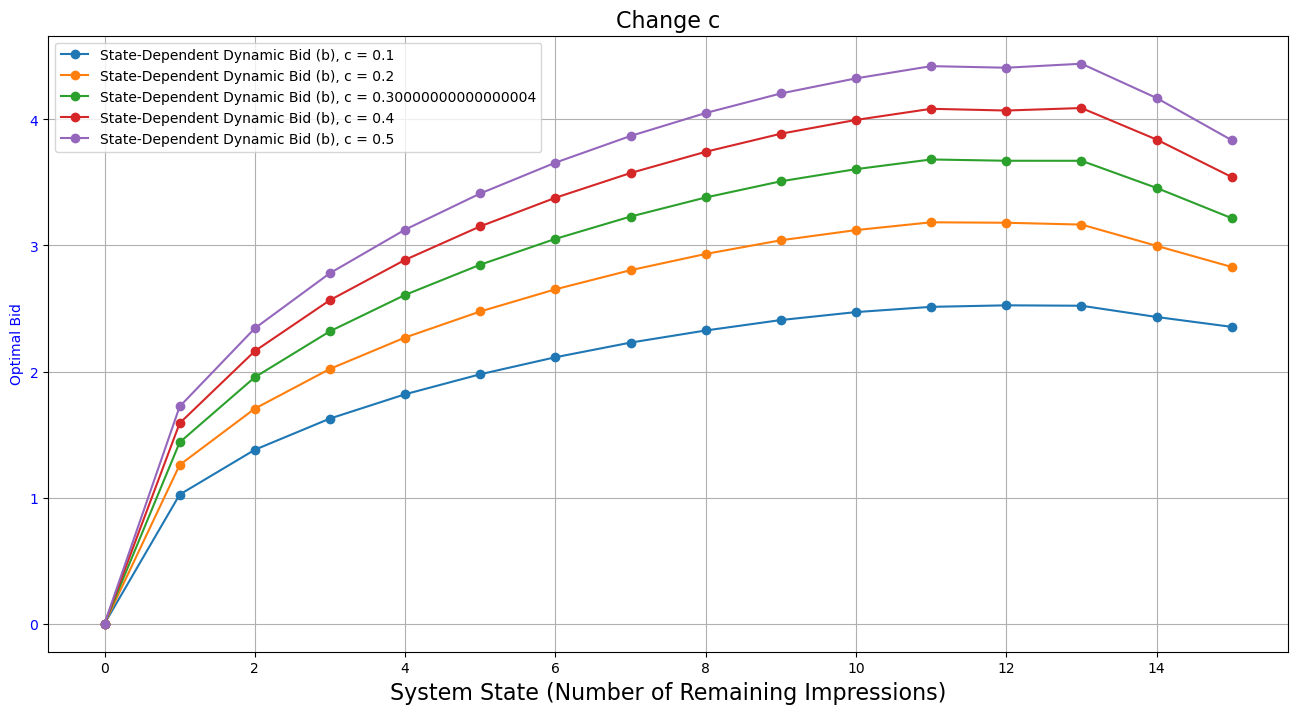

In [15]:
# 6.4.4 Financial Parameter r and c
mu_base = 1.0
lambda_Cap_base = 0.2
A_base = 15
revenue_base = 5
dcost_list = np.arange(0.1,0.6,0.1)
rho_0_base = mu_base / lambda_Imp_base


# 设置基本案例参数并求解
q_s_base = compute_q(A_base)
x_list,b_list,w_list,opt_profit_list = [],[],[],[]
for dcost_base in dcost_list:
    x_base, b_base, w_base, optimal_profit_base = solve_steady_state(A_base, mu_base, revenue_base, dcost_base, lambda_Cap_base, q_s_base)
    # 存下当前gamma下的结果
    x_list.append(x_base)
    b_list.append(b_base)
    w_list.append(w_base)
    opt_profit_list.append(optimal_profit_base)
    # 输出结果
    print(f'c = {dcost_base}')
    Result = pd.DataFrame(columns = [f'Sys State: {i}' for i in range(A_base+1)])
    Result.loc['Opt x'] = x_base 
    Result.loc['Opt b'] = b_base 
    Result.loc['Opt w'] = w_base
    display(Result)
    print(f"Optimal Expected Profit: {optimal_profit_base:.2f}")

plt.figure(figsize = (16,8))
for idx in range(len(dcost_list)):
    x_base = x_list[idx]
    b_base = b_list[idx]
    w_base = w_list[idx] 
    optimal_profit_base = opt_profit_list[idx]
    
    # 找到 b_base 的最大值及其对应的索引
    max_bid = np.max(b_base)
    max_bid_index = np.argmax(b_base)

    # 绘制 Optimal Bids (b)
    plt.plot(range(A_base + 1), b_base, label=f"State-Dependent Dynamic Bid (b), c = {dcost_list[idx]}", marker='o')

plt.title('Change c',fontsize = 16)
plt.xlabel("System State (Number of Remaining Impressions)", fontsize=16)
plt.ylabel("Optimal Bid", color='blue')
plt.tick_params(axis='y', labelcolor='blue')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

r = 3


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.273043,0.138133,0.166369,0.109991,0.092765,0.064622,0.048253,0.033583,0.023794,0.016391,0.011351,0.007783,0.005396,0.003753,0.002733,0.002040
Opt b,0.000000,1.257692,1.704512,2.016830,2.264798,2.468871,2.641305,2.788485,2.910854,3.010748,3.078128,3.119516,3.087411,3.029929,2.768188,2.525950
Opt w,0.000000,0.395333,0.494297,0.553686,0.595830,0.627511,0.652337,0.672214,0.687872,0.700098,0.708073,0.712866,0.709155,0.702390,0.669542,0.635919


Optimal Expected Profit: -0.21
r = 4


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.273531,0.138315,0.166598,0.110049,0.092794,0.064590,0.048192,0.033503,0.023703,0.016298,0.011257,0.007690,0.005302,0.003656,0.002616,0.001906
Opt b,0.000000,1.258461,1.705116,2.019369,2.267476,2.472817,2.647144,2.796498,2.922477,3.026631,3.100881,3.152793,3.135565,3.100191,2.886523,2.683765
Opt w,0.000000,0.395519,0.494419,0.554139,0.596263,0.628099,0.653148,0.673263,0.689320,0.701997,0.710718,0.716663,0.714703,0.710638,0.684819,0.658192


Optimal Expected Profit: 0.19
r = 5


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.274011,0.138477,0.166792,0.110107,0.092809,0.064553,0.048130,0.033424,0.023617,0.016210,0.011169,0.007603,0.005216,0.003570,0.002516,0.001796
Opt b,0.000000,1.259417,1.706082,2.021372,2.270226,2.476735,2.652553,2.804198,2.933074,3.041480,3.122274,3.184092,3.180420,3.165918,2.997349,2.829480
Opt w,0.000000,0.395750,0.494614,0.554496,0.596706,0.628681,0.653898,0.674268,0.690634,0.703762,0.713183,0.720188,0.719777,0.718146,0.698486,0.677545


Optimal Expected Profit: 0.59
r = 6


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.274469,0.138639,0.166957,0.110157,0.092814,0.064515,0.048068,0.033348,0.023535,0.016126,0.011087,0.007523,0.005138,0.003492,0.002428,0.001705
Opt b,0.000000,1.260232,1.707336,2.023278,2.272897,2.480409,2.657714,2.811402,2.943121,3.055859,3.142223,3.213718,3.222577,3.227988,3.102016,2.965304
Opt w,0.000000,0.395947,0.494867,0.554835,0.597137,0.629226,0.654612,0.675205,0.691875,0.705461,0.715462,0.723484,0.724462,0.725058,0.710849,0.694597


Optimal Expected Profit: 0.99
r = 7


,Sys State: 0,Sys State: 1,Sys State: 2,Sys State: 3,Sys State: 4,Sys State: 5,Sys State: 6,Sys State: 7,Sys State: 8,Sys State: 9,Sys State: 10,Sys State: 11,Sys State: 12,Sys State: 13,Sys State: 14,Sys State: 15
Opt x,0.274895,0.138826,0.167094,0.110202,0.092810,0.064473,0.048003,0.033274,0.023455,0.016048,0.011006,0.007454,0.005058,0.003425,0.002353,0.001625
Opt b,0.000000,1.260567,1.708960,2.025325,2.275479,2.484005,2.662706,2.818002,2.952773,3.068739,3.163078,3.236127,3.273243,3.279269,3.192221,3.104134
Opt w,0.000000,0.396028,0.495195,0.555200,0.597553,0.629759,0.655300,0.676061,0.693062,0.706975,0.717826,0.725952,0.729990,0.730640,0.721096,0.711094


Optimal Expected Profit: 1.39


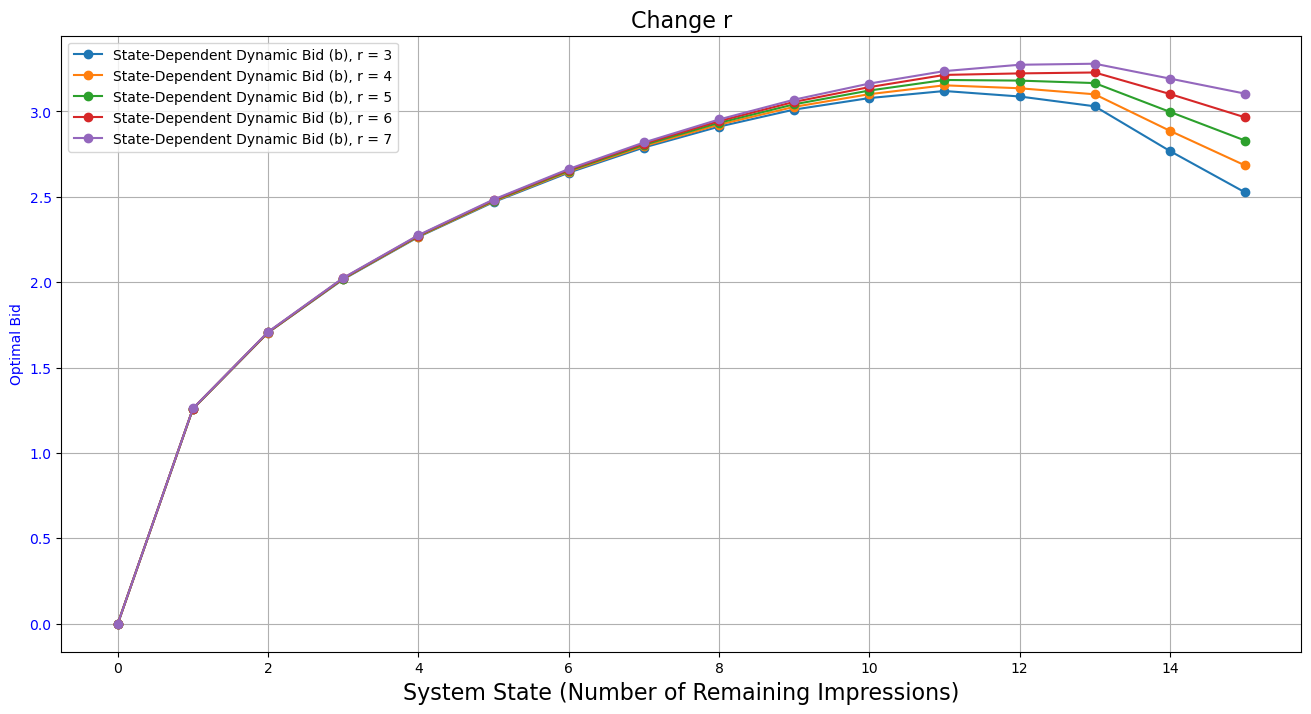

In [16]:
# 6.4.4 Financial Parameter r and c
mu_base = 1.0
lambda_Cap_list = 0.2
A_base = 15
revenue_list = np.arange(3,8,1)
dcost_base = 0.2
rho_0_base = mu_base / lambda_Imp_base

# 设置基本案例参数并求解
q_s_base = compute_q(A_base)
x_list,b_list,w_list,opt_profit_list = [],[],[],[]
for revenue_base in revenue_list:
    x_base, b_base, w_base, optimal_profit_base = solve_steady_state(A_base, mu_base, revenue_base, dcost_base, lambda_Cap_base, q_s_base)
    # 存下当前gamma下的结果
    x_list.append(x_base)
    b_list.append(b_base)
    w_list.append(w_base)
    opt_profit_list.append(optimal_profit_base)
    # 输出结果
    print(f'r = {revenue_base}')
    Result = pd.DataFrame(columns = [f'Sys State: {i}' for i in range(A_base+1)])
    Result.loc['Opt x'] = x_base 
    Result.loc['Opt b'] = b_base 
    Result.loc['Opt w'] = w_base
    display(Result)
    print(f"Optimal Expected Profit: {optimal_profit_base:.2f}")

plt.figure(figsize = (16,8))
for idx in range(len(revenue_list)):
    x_base = x_list[idx]
    b_base = b_list[idx]
    w_base = w_list[idx] 
    optimal_profit_base = opt_profit_list[idx]
    
    # 找到 b_base 的最大值及其对应的索引
    max_bid = np.max(b_base)
    max_bid_index = np.argmax(b_base)

    # 绘制 Optimal Bids (b)
    plt.plot(range(A_base + 1), b_base, label=f"State-Dependent Dynamic Bid (b), r = {revenue_list[idx]}", marker='o')

plt.title('Change r',fontsize = 16)
plt.xlabel("System State (Number of Remaining Impressions)", fontsize=16)
plt.ylabel("Optimal Bid", color='blue')
plt.tick_params(axis='y', labelcolor='blue')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()